In [2]:
# Importing Necessary Packages
#------------------------------------------------------------------------

# General
import warnings                                                             
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

# Scikit-Learn and Scipy
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

# Visualization
import matplotlib.pyplot as plt

In [3]:
# Loading in Relevant Data
#------------------------------------------------------------------------
diabetes = load_diabetes(scaled = True)     
df = pd.DataFrame(data = diabetes.data, columns = diabetes.feature_names)
df['target'] = diabetes.target

def MaleOrFemale(x):
    if x < 0: return 0
    return 1

df['sex'] = df['sex'].apply(lambda x: MaleOrFemale(x))
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,1,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,0,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,1,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,0,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,0,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,1,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,1,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,1,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,0,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


<hr>
<p style="text-align:center; font-size:x-large; color:black;"> Regularization Methods </p>
<hr>

__Regularization__ is a technique that is used to prevent overfitting of models and provide models with better generalization capability. __Overfitting__ ocurrs when we fit a model, and our model has learned some sort of underlying pattern within the training data. When we test an overfitted model on some testing data, we would probably notice poor performance.

In order to provide more generalization, regularization methods apply extra constraints on the orginal model's parameters during training to discourage overly complex models. There are 2 main types of regularization.
- __L1__: Also known as __Lasso Regularization__
- __L2__: Also known as __Ridge Regurlarization__ <br>

There is also a 3rd type of regularization technique called __Elastic Net Regularization__, which combines L1 and L2.

<p style="text-align:left; font-size:x-large; color:black;"> Least Absolute Shrinkage and Selection Operation (LASSO) Regression</p>

__LASSO Regression__ is a linear regression technique that adds a penalty term to the OLS optimization problem, where the penalty is the absolute value of the coefficients multiplied by a regularization parameter (&alpha; or &lambda;). This penalty is called Lasso regularization.
$$
\text{Original OLS Optimization:}
$$
$$
\min_{\beta} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^{2}
$$
$$
\text{Lasso Regression Optimization:}
$$
$$
\min_{\beta} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^{2} + \lambda \sum_{j=1}^{p} | \beta_{j} |
$$
Here's how would would run a Lasso Regression in Python, using __sklearn.linear_model__. I will also compare these coefficients of our Lasso regression to a standard OLS regression.

In [3]:
lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(df[df.columns.drop('target')], df['target'])

OLS_model = LinearRegression()
OLS_model.fit(df[df.columns.drop('target')], df['target'])

# .feature_names_in_ gets you the predictor variables
# .coef_ gets you their respective coefficients
model_results = pd.DataFrame({'Lasso Coefficients': lasso_model.coef_,
                              'OLS Coefficients': OLS_model.coef_})
model_results.index = lasso_model.feature_names_in_
model_results

,Lasso Coefficients,OLS Coefficients
age,0.000000,-10.009866
sex,-19.595203,-22.859648
bmi,509.339639,519.845920
bp,285.995384,324.384646
s1,-49.002732,-792.175639
s2,-0.000000,476.739021
s3,-231.248201,101.043268
s4,0.000000,177.063238
s5,478.083337,751.273700
s6,38.695827,67.626692


As we see, with an alpha of 0.1, the coefficients of 'age', 's2', and 's4' were shrank down to 0. This is ultimately what Lasso Regularization does. Depending on the alpha, more and more coefficients will be shrunk to 0, which is effectively __feature selection__. Below is a depiction of how the coefficients of our predictors change with respect to a change in our regularization parameter.

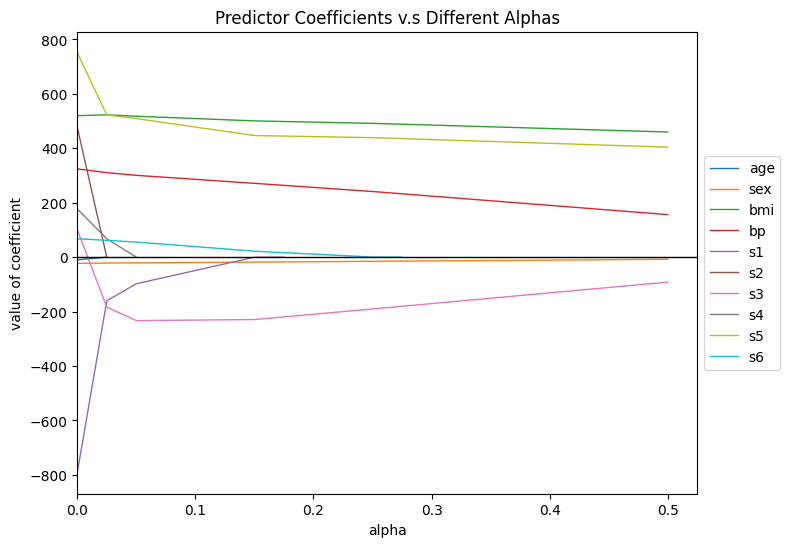

In [4]:
lasso_coefs = pd.DataFrame(columns = df.columns.drop('target'))

alphas = np.linspace(0, 0.5, 21)

for a in alphas:
    lasso = Lasso(alpha = a)  # alpha is the regularization parameter
    lasso.fit(df[df.columns.drop('target')], df['target'])
    lasso_coefs.loc[len(lasso_coefs)] = lasso.coef_

lasso_coefs.index = alphas


# Visualization intricacies
fig = plt.figure(figsize = (8, 6))
for col in df.columns.drop('target'):

    first_zero_found = len(lasso_coefs)
    for i in range(len(lasso_coefs)):
        if lasso_coefs.iloc[i][col] == 0:
            first_zero_found = min(first_zero_found, i)

    plt.plot(lasso_coefs.index[0:first_zero_found + 1], lasso_coefs.iloc[0:first_zero_found + 1][col], linewidth = 1, label = col)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = 0, color = 'black', linestyle ='-', linewidth = 1)
plt.title('Predictor Coefficients v.s Different Alphas')
plt.xlabel('alpha')
plt.ylabel('value of coefficient')
plt.xlim(left = 0)
plt.show()

With an alpha of 0.5, we see that 'bmi', 'bp', 's5', 'sex', and 's3' are the only non-zero coefficients that remain. This speaks to the predictors overall impact on our response variable.

<p style="text-align:left; font-size:x-large; color:black;"> Ridge Regression</p>

__Ridge Regression__ introduces L2 regularization, which adds a penalty term proportional to the square of the model's coefficients. 
$$
\text{Original OLS Optimization:}
$$
$$
\min_{\beta} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^{2}
$$
$$
\text{Ridge Regression Optimization:}
$$
$$
\min_{\beta} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^{2} + \lambda \sum_{j=1}^{p} (\beta_{j})^{2}
$$
Below is an example of how we would fit a Ridge Regression in Python. I will also compare the reuslts of the coefficients to a standard OLS model.

In [8]:
ridge_model = Ridge(alpha = 0.1)
ridge_model.fit(df[df.columns.drop('target')], df['target'])

OLS_model = LinearRegression()
OLS_model.fit(df[df.columns.drop('target')], df['target'])

model_results = pd.DataFrame({'Lasso Coefficients': ridge_model.coef_,
                              'OLS Coefficients': OLS_model.coef_})
model_results.index = ridge_model.feature_names_in_
model_results

,Lasso Coefficients,OLS Coefficients
age,3.631063,-10.009866
sex,-22.189231,-22.859648
bmi,486.544675,519.845920
bp,306.187811,324.384646
s1,-86.089891,-792.175639
s2,-69.342236,476.739021
s3,-194.719867,101.043268
s4,119.864142,177.063238
s5,441.919787,751.273700
s6,88.603860,67.626692


If we compare our results to the Lasso Regression, we realized that the coefficients didn't shrink down to 0. This is because Ridge Regularization encourages smaller coefficients and effectively prevents any single feature from having an overwhelming influence on our model. Shrinking these coefficients helps us deal with __multicollinearity__.

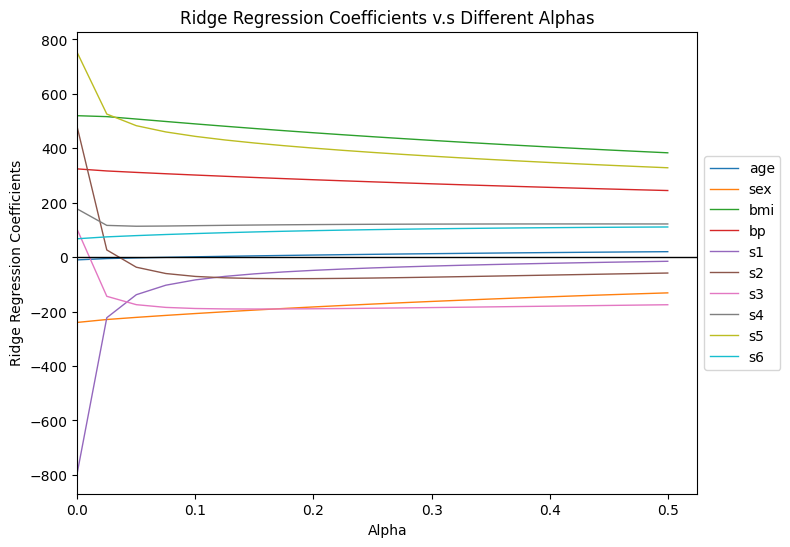

In [7]:
ridge_coefs = pd.DataFrame(columns = df.columns.drop('target'))
alphas = np.linspace(0, 0.5, 21)

for a in alphas:
    ridge = Ridge(alpha = a)  # alpha is the regularization parameter
    ridge.fit(df[df.columns.drop('target')], df['target'])
    ridge_coefs.loc[len(ridge_coefs)] = ridge.coef_

ridge_coefs.index = alphas


# Visualization Intricacies
fig = plt.figure(figsize = (8, 6))
for col in df.columns.drop('target'):

    first_zero_found = len(ridge_coefs)
    for i in range(len(ridge_coefs)):
        if ridge_coefs.iloc[i][col] == 0:
            first_zero_found = min(first_zero_found, i)

    plt.plot(ridge_coefs.index[0:first_zero_found + 1], ridge_coefs.iloc[0:first_zero_found + 1][col], linewidth = 1, label = col)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = 0, color = 'black', linestyle ='-', linewidth = 1)
plt.title('Ridge Regression Coefficients v.s Different Alphas')
plt.xlabel('Alpha')
plt.ylabel('Ridge Regression Coefficients')
plt.xlim(left = 0)
plt.show()

<p style="text-align:left; font-size:x-large; color:black;"> Elastic Net Regression </p>

__Elastic Net Regression__ incorporates both L1 and L2 regularization, so we can imagine this as combinining a Lasso and Ridge Regression. Because of this combination, Elastic Net Regression is an effective way to deal with feature selection (from Lasso Regression) and Multicollinearity (from Ridge Regression).

$$
\text{Original OLS Optimization:}
$$
$$
\min_{\beta} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^{2}
$$
$$
\text{Elastic Net Regression Optimization:}
$$
$$
\min_{\beta} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^{2} + \lambda_{1} \sum_{j=1}^{p} |\beta_{j}| + \lambda_{2} \sum_{j=1}^{p} (\beta_{j})^{2}
$$
Below is an example of how we would fit an Regression in Python. the __L1 Ratio__ determines what proportion of the alpha is given towards the L1 regularization. For example, if alpha = 0.1, and l1_ratio = 0.6, then the L1 regularization has an alpha of 0.06, while the L2 regularization has an alpha of 0.04.

In [12]:
ElasticNet_model = ElasticNet(alpha = 0.2, l1_ratio = 0.5)
ElasticNet_model.fit(df[df.columns.drop('target')], df['target'])

OLS_model = LinearRegression()
OLS_model.fit(df[df.columns.drop('target')], df['target'])

model_results = pd.DataFrame({'Lasso Coefficients': ElasticNet_model.coef_,
                              'OLS Coefficients': OLS_model.coef_})
model_results.index = ElasticNet_model.feature_names_in_
model_results

,Lasso Coefficients,OLS Coefficients
age,5.123332,-10.009866
sex,3.024375,-22.859648
bmi,19.261311,519.845920
bp,14.024501,324.384646
s1,5.854188,-792.175639
s2,4.395052,476.739021
s3,-12.214330,101.043268
s4,13.233890,177.063238
s5,18.334882,751.273700
s6,11.799628,67.626692


Visualizing the effects of changes in parameters is complicated for ElasticNet Regression since there is an L1 and L2 regularization parameter at play, therefore I'll keep the L1-ratio constant at 0.5.

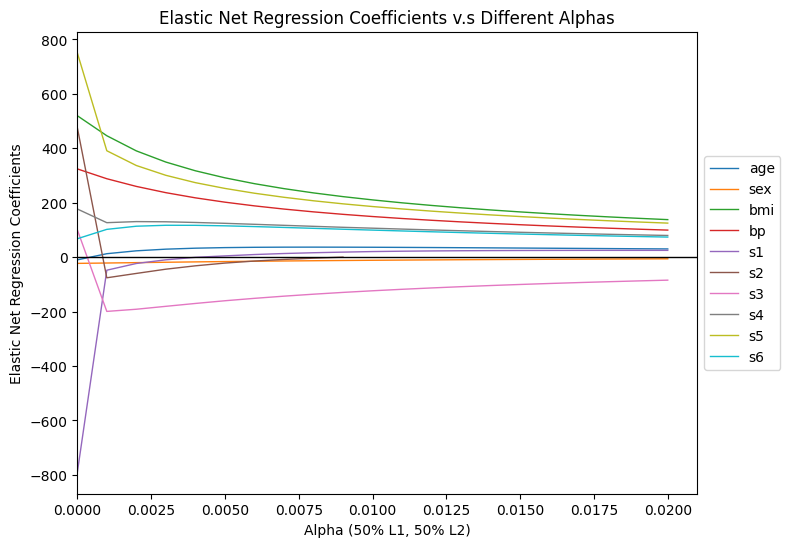

In [17]:
ElasticNet_coefs = pd.DataFrame(columns = df.columns.drop('target'))
alphas = np.linspace(0, 0.02, 21)

for a in alphas:
    ElasticNet_model = ElasticNet(alpha = a, l1_ratio = 0.5)  # alpha is the regularization parameter
    ElasticNet_model.fit(df[df.columns.drop('target')], df['target'])
    ElasticNet_coefs.loc[len(ElasticNet_coefs)] =  ElasticNet_model.coef_

ElasticNet_coefs.index = alphas


# Visualization Intricacies
fig = plt.figure(figsize = (8, 6))
for col in df.columns.drop('target'):

    first_zero_found = len(ElasticNet_coefs)
    for i in range(len(ElasticNet_coefs)):
        if ElasticNet_coefs.iloc[i][col] == 0:
            first_zero_found = min(first_zero_found, i)

    plt.plot(ElasticNet_coefs.index[0:first_zero_found + 1], ElasticNet_coefs.iloc[0:first_zero_found + 1][col], linewidth = 1, label = col)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = 0, color = 'black', linestyle ='-', linewidth = 1)
plt.title('Elastic Net Regression Coefficients v.s Different Alphas')
plt.xlabel('Alpha (50% L1, 50% L2)')
plt.ylabel('Elastic Net Regression Coefficients')
plt.xlim(left = 0)
plt.show()

As we can see, when both L1 and L2 regularization are at play, coefficients become small very quickly.

<hr>
<p style="text-align:center; font-size:x-large; color:black;"> Hyperparameter Tuning </p>
<hr>

A __hyperparameter__ is a setting or configuration that's specified prior to the training process of our machine learning model. These hyperparameters control various aspects of the learning process and model architecture, influencing how the model learns and generalizes from the training data. Since these parameters can't be learned from the data during training, we need to set them beforehand. When it comes to regularization, our hyperparameters are our &lambda;<sub>1</sub> and &lambda;<sub>2</sub> terms. Setting the most optimal hyperparameters of a machine learning model is done through the process called __hyperparameter tuning__.

As mentioned in the __Cross Validation__ jupyter notebook, hyperparameter tuning often utilizes Nested CV. In a K-Fold or Leave-One-Out CV, data is simulataneously used as training AND testing data. Because of this, our 'ideal' model tends to overfit the test data, and the estimation leads to an optimistic bias. This is called __leakage__. <br>

Nested Cross-Validation eliminates leakage by implementing 2 layers of CV (either 2 K-Folds, 2 Leave-One-Outs, or 1 of each). This way, we can tune a hyperparameter with the inner layer of training-testing data, and validate the resulting model's performance on the outer cross-validation's testing data, which has data that was not used to tune the hyperparameter. This gives us a better understanding of a model's general performance. <br> 

<p style="text-align:left; font-size:x-large; color:black;"> Hyperparameter Tuning Example: Lasso Regression</p>

First, I want to define the inner CV method. I'll be using Leave-One-Out for the inner layer to get consistent performance evaluations (MSE in this case). <br> 

An added layer of complexity when it comes to hyperparemeter tuning is that we have to look through multiple values our hyperparameter can take, and then perform our CV on each value to determine which value produces the best performance metric. To do this we can implement something called __GridSearchCV__ or __RandomizedSearchCV__.
- __GridSearchCV:__ This searches through a specified subset of the hyperparameter space. This method can be computationally intensive if we are trying to tune multiple hyperparameters (e.g in Elastic-Net Regression) at the same time since it will search through every possible combination of values. Becuase of this, GridSearch is best suited to look through small hyperparameter spaces.

- __RandomizedSearchCV:__ This searches through a specified number of points from the hyperparameter space. This is generally less intensive than GridSearch, so this is ideal when we are exploring a large hyperparameter space.

<p style="text-align:left; font-size:large; color:black;"> <b>GridSearchCV Implementation (Inner CV)</b></p>

In [8]:
def GridTune(df, pred_vars, alphas, regularization_type):

    model = None

    if regularization_type == 'L1':
        model = Lasso()
    elif regularization_type == 'L2':
        model = Ridge()
    else:
        return None
    
    params_to_search = {'alpha' : alphas}
    inner_cross_validation = LeaveOneOut()

    search =  GridSearchCV(estimator = model,
                        param_grid = params_to_search,
                        cv = inner_cross_validation,
                        scoring = 'neg_mean_squared_error')
    search.fit(df[pred_vars], df['target'])

    return [search.best_params_['alpha'], -search.best_score_]

<p style="text-align:left; font-size:large; color:black;"> <b>RandomizedSearchCV Implementation (Inner CV)</b></p>

In [9]:
def RandomizedTune(df, pred_vars, alphas, regularization_type):

    model = None

    if regularization_type == 'L1':
        model = Lasso()
    elif regularization_type == 'L2':
        model = Ridge()
    else:
        return None
    
    param_space = {'alpha' : alphas}

    inner_cross_validation = LeaveOneOut()

    search =  RandomizedSearchCV(estimator = model,
                                param_distributions = param_space,
                                n_iter = 50,
                                cv = inner_cross_validation,
                                scoring = 'neg_mean_squared_error')
    search.fit(df[pred_vars], df['target'])

    return [search.best_params_['alpha'], -search.best_score_]

Now that we have defined the inner CV method to find the besst hyperparameter, we need to define the outer CV method so that we can obtain a generalized performance of our model. For this example, I will use 5-Fold CV as my outer CV. For my first search, I will implement a GridSearch over the integers 0-10. This way, I can get a rough idea of where the ideal &lambda; value is. 

In [10]:
outer_cross_validation = KFold(n_splits = 5, shuffle = True)
results = pd.DataFrame(columns = ['alpha', 'MSE on Unseen Data'])

for train_index, test_index in outer_cross_validation.split(df):

    results.loc[len(results)] = GridTune(df = df.loc[train_index], 
                                                pred_vars = df.columns.drop('target'),
                                                alphas = np.linspace(0, 10, 11), 
                                                regularization_type = 'L1')

results.index = [f'Fold {i+1}' for i in range(5)]
results

,alpha,MSE on Unseen Data
Fold 1,0.0,3017.567474
Fold 2,0.0,2924.241448
Fold 3,0.0,3123.966361
Fold 4,0.0,3004.089663
Fold 5,0.0,3016.292571


From these results, we can see that a &lambda; of 0 produces the best Lasso Regression results when looking at the integers 0-10. I am going to do another GridSearch, but this time, I am going to look through a more refined grid with min 0 and max 1.

In [11]:
outer_cross_validation = KFold(n_splits = 5, shuffle = True)
results = pd.DataFrame(columns = ['alpha', 'MSE on Unseen Data'])

for train_index, test_index in outer_cross_validation.split(df):

    results.loc[len(results)] = GridTune(df = df.loc[train_index], 
                                                pred_vars = df.columns.drop('target'),
                                                alphas = np.linspace(0, 1, 21), 
                                                regularization_type = 'L1')

results.index = [f'Fold {i+1}' for i in range(5)]
results

,alpha,MSE on Unseen Data
Fold 1,0.05,2985.474862
Fold 2,0.05,2947.602154
Fold 3,0.10,3074.427876
Fold 4,0.05,3044.317175
Fold 5,0.00,2989.036343


Now, we can be fairly confident that our optimal &lambda; is between 0 and 0.1. Since 0.05 appeared the most within these folds, it would be fair to say that a potential optimal value is &lambda; = 0.05. However, I am going to do an additional RandomizedSearch from 0 to 0.1, just to get some more estimates.

In [13]:
outer_cross_validation = KFold(n_splits = 5, shuffle = True)
results = pd.DataFrame(columns = ['alpha', 'MSE on Unseen Data'])

for train_index, test_index in outer_cross_validation.split(df):

    results.loc[len(results)] = RandomizedTune(df = df.loc[train_index], 
                                                pred_vars = df.columns.drop('target'),
                                                alphas = uniform(0, 0.1), 
                                                regularization_type = 'L1')

results.index = [f'Fold {i+1}' for i in range(5)]
results

,alpha,MSE on Unseen Data
Fold 1,0.099940,3035.334850
Fold 2,0.007577,2975.175331
Fold 3,0.005770,2959.070263
Fold 4,0.078256,2993.607388
Fold 5,0.036065,3026.810883


We finally have a bunch of alphas along with their generalized performance metrics. To further compare these hyperparameters, we can rerun Lasso Regressions with each L1 hyperparameter several times to obtain a distribution of a performance metric over multiple train/test splits. We can then utilize statistical tests like ANOVA or T-Tests to determine which hyperparameter generally perofrms better.